In [1]:
"""
Trains a character-level language model.
"""

import os
import sys

import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

from mingpt.model import GPT
from mingpt.trainer import Trainer
from mingpt.utils import set_seed, setup_logging, CfgNode as CN

from nndrain.tensor_edit import TensorEdit
from nndrain.simplify_linear import SimplifyLinear
import nndrain.utils as utils


In [2]:
class CharDataset(Dataset):
    """
    Emits batches of characters
    """

    @staticmethod
    def get_default_config():
        C = CN()
        C.block_size = 128
        return C

    def __init__(self, config, data):
        self.config = config

        chars = sorted(list(set(data)))
        data_size, vocab_size = len(data), len(chars)
        print('data has %d characters, %d unique.' % (data_size, vocab_size))

        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
        self.vocab_size = vocab_size
        self.data = data

    def get_vocab_size(self):
        return self.vocab_size

    def get_block_size(self):
        return self.config.block_size

    def __len__(self):
        return len(self.data) - self.config.block_size

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        chunk = self.data[idx:idx + self.config.block_size + 1]
        # encode every character to an integer
        dix = [self.stoi[s] for s in chunk]
        # return as tensors
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y

In [3]:
def get_config():

    C = CN()

    # system
    C.system = CN()
    C.system.seed = 3407
    C.system.work_dir = './out/chargpt'

    # data
    C.data = CharDataset.get_default_config()

    # model
    C.model = GPT.get_default_config()
    C.model.model_type = 'gpt-mini'

    # trainer
    C.trainer = Trainer.get_default_config()
    C.trainer.num_workers = 0
    C.trainer.learning_rate = 6e-4 # the model we're using is so small that we can go a bit faster
    C.trainer.batch_size = 128
    C.trainer.max_iters = 50000
    return C


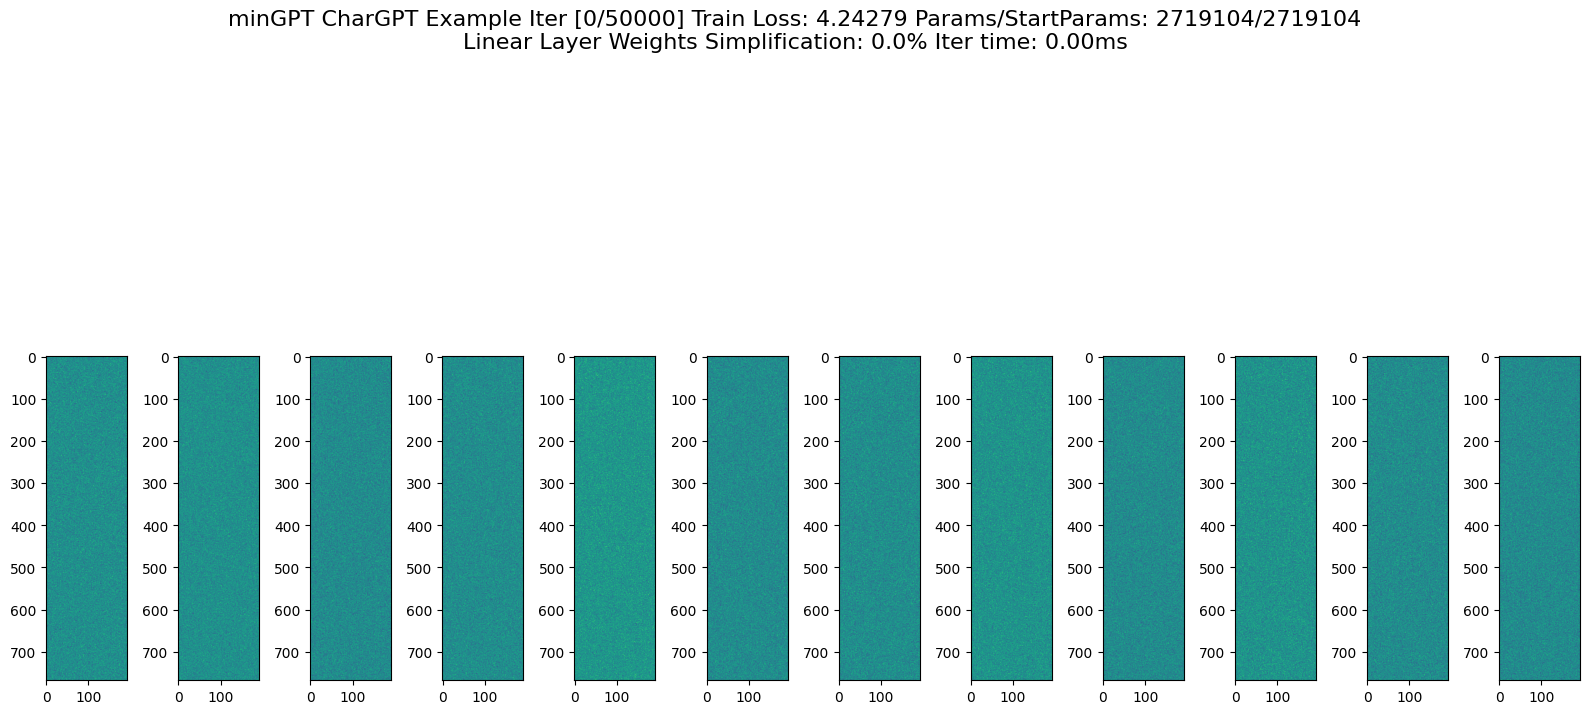

O God, O God! tiZbgu s yha ayerora s biobo&shiyrhwite i ti sthebrybobrertthor oo ouasewrtrteorowiyyryth toerirbrheQtb
Hsy oohaythhe y ttaH arithouetrb
tryatohiro tiobthi itrimorth toreo y to thrbtorebot tta anthtaihtar ea  oto etrirtu taetootot o are tu ihete ouo&ob oHtro a yrrbL orrbraet sisrar srrb
ttaHN
ou i strob
taroatuoHr mythhorb t oHbgthh mhtaryarrb
Ara that tierb
eN thaetortri toh, atou t y sb h h,QyeQoroo ettouth seoortustisorerb
haterot ayt eQyre aroryoub
o stirHht ar myI teNsb yoh hroustb
th aeet
iter_dt 7417.64ms; iter 10: train loss 2.93429
iter_dt 7448.65ms; iter 20: train loss 2.69433


In [4]:
# get default config and overrides from the command line, if any
config = get_config()

print(config)
setup_logging(config)
set_seed(config.system.seed)

# construct the training dataset
text = open('input_shakespeare.txt', 'r').read() # don't worry we won't run out of file handles
train_dataset = CharDataset(config.data, text)

# construct the model
config.model.vocab_size = train_dataset.get_vocab_size()
config.model.block_size = train_dataset.get_block_size()

model = GPT(config.model)
#ckpt_path = os.path.join(config.system.work_dir, "model.pt")
#model = torch.load(ckpt_path)

####################################
n_start_params = sum(p.numel() for p in model.parameters())
simplify_layers = [module for module in model.modules() if isinstance(module, SimplifyLinear)]
te = TensorEdit(simplify_layers)
fig, fig_chart = None, None
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 10), facecolor='white')    
filenames = []
outdir = 'out/chargpt'
####################################

# construct the trainer object
trainer = Trainer(config.trainer, model, train_dataset)

# iteration callback
def batch_end_callback(trainer):

    epoch = int(trainer.iter_num/1) #define an arbitrary epoch just to periodically execute the underlying methods
    te.set_threshold()
    te.weights_drain(p_drain=0.1, threshold_coeff=3.0, condition=epoch!=0 and epoch%5==0)
    te.weights_decay(p_decay=0.1, decay_rate=5e-3, condition=epoch!=0 and epoch%3==0)

    removed = False
    if trainer.iter_num % 10 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        #for l in te.layers:
        #    print(f"Set threshold: {l.threshold}")
        # remove weights if all values ​​in a row or column are less than the specified value
        if te.weights_remove(p_remove=1, threshold_coeff=0.1, max_removal=1.0, verbose=True):
            # re-instantiate the optimizer with the new model if I have deleted any rows or columns
            trainer.optimizer = model.configure_optimizers(config.trainer)

    if trainer.iter_num % 100 == 0:

        n_params = sum(p.numel() for p in model.parameters())
        simplification = (1-n_params/n_start_params)*100
        print("number of parameters: {:.3e} simplification: {:.1f}%".format(n_params, simplification))

        # plot
        weights = [w.weight.data.T if w.weight.data.size()[1]>w.weight.data.size()[0] else w.weight.data for w in simplify_layers]

        title1 = "minGPT CharGPT Example Iter [{}/{}] Train Loss: {:.5f} Params/StartParams: {}/{}"\
                    .format(trainer.iter_num, config.trainer.max_iters, trainer.loss.item(), n_params, n_start_params)
        title2 = "Linear Layer Weights Simplification: {:.1f}% Iter time: {:.2f}ms"\
                    .format(simplification, trainer.iter_dt * 1000)

        utils.plot_weights(fig, weights, '\n'.join((title1, title2)))
        
        # create a file name, append it to the filenames list
        filename = '/'.join((outdir, f'frame_{epoch+1}.png'))
        filenames.append(filename)
        # and save the figure
        fig.savefig(filename, facecolor=fig.get_facecolor())
        plt.clf()

        # evaluate both the train and test score
        model.eval()
        with torch.no_grad():
            # sample from the model...
            context = "O God, O God!"
            x = torch.tensor([train_dataset.stoi[s] for s in context], dtype=torch.long)[None,...].to(trainer.device)
            y = model.generate(x, 500, temperature=1.0, do_sample=True, top_k=10)[0]
            completion = ''.join([train_dataset.itos[int(i)] for i in y])
            print(completion)
            
        if trainer.iter_num>0:
            # save the latest model
            print("saving model")
            ckpt_path = os.path.join(config.system.work_dir, "model.pt")
            torch.save(model, ckpt_path)
        # revert model to training mode
        model.train()

trainer.set_callback('on_batch_end', batch_end_callback)

# run the optimization
trainer.run()

In [ ]:
# build a gif by composing the frames
utils.images_to_gif(filenames, '/'.join((outdir, 'chargpt.gif')), tail=100)

# create a mjpg video
utils.images_to_avi(filenames, '/'.join((outdir, 'chargpt.avi')))

# Remove frame files
for filename in set(filenames):
    os.remove(filename)